In [1]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

%config InlineBackend.figure_formats = ['svg']

In [2]:
import numpy as np
import qiskit, qiskit_ibm_provider
import utility as ut
import pickle
import datetime 

today = datetime.datetime.now()

print(f'Now is {today}')

Now is 2024-08-22 18:44:09.260574


#### Select provider & specify hardware

In [78]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')
qubit = 109
clbit = 0
num_qubits = int(qubit+1)
num_clbits = int(1.0)

f01 = backend.defaults().qubit_freq_est[qubit]
f12 = f01 + backend.properties().qubits[qubit][3].value * 1.0e9

print(r"Frequency $f_{01}$ = "+f'{round(f01/1e9, 4)}'+' GHz')
print(r'Frequency $f_{12}$ = '+f'{round(f12/1e9, 4)}'+' GHz')
print(r'Anharmonicity $\alpha$ = '+f'{round((f01-f12)/1e9, 4)}'+' GHz')

Frequency $f_{01}$ = 4.985 GHz
Frequency $f_{12}$ = 4.6779 GHz
Anharmonicity $\alpha$ = 0.3071 GHz


#### Rabi-calibrated pulse parameters

In [4]:
dur12 = 120
amp_x12 = 0.16456880022602943
amp_sx12 = amp_x12/2

#### PE parameters

In [62]:
dur = int(input('Chosen pulse duration:'))
amp_x12 = float(input('Rabi-calibrated amplitude:'))
rep = int(input('Indicate rep_range:'))
pe_shots = int(input('Number of shots:'))

amp_sx12 = amp_x12/2
rep_range = [2*r+1 for r in range(rep)]
angle_swept = np.linspace(-np.pi/6, -np.pi/6 + 2 * np.pi, 75)

In [64]:
print(f'Sweeping from {min(angle_swept)} to {max(angle_swept)}...')
print(f'Chosen duration {dur}')
print(f'Shots per data point {pe_shots}')
print(f'Repetition range {rep_range}')

Sweeping from -0.5235987755982988 to 5.759586531581287...
Chosen duration 120
Shots per data point 2048
Repetition range [1, 3, 5, 7]


#### PE circuit

In [65]:
def schedule_builder(params, name, frequency=f12):
    """
        Build a schedule for pulse on 12
    """

    num_pulse = params['num_pulse']

    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(frequency, drive_chan)
        for n in range(num_pulse):
            with qiskit.pulse.phase_offset(params['angle'][n], drive_chan):
                qiskit.pulse.delay(16, drive_chan)
                qiskit.pulse.play(qiskit.pulse.Drag(duration=params['dur'][n],
                                                    amp=params['amp'][n], 
                                                    sigma=int(params['dur'][n]/4), 
                                                    beta=params['beta'][n],
                                                    name=name), drive_chan)
    return schedule
    
def gate(name, weight):
    return qiskit.circuit.Gate(name, weight, [])

with qiskit.pulse.build(backend=backend, name='Spectroscopy') as measure_schedule:
    meas_chan = qiskit.pulse.measure_channel(qubit)
    ac_chan = qiskit.pulse.acquire_channel(qubit)
    mem_chan = qiskit.pulse.MemorySlot(0)
    qiskit.pulse.acquire(1440, ac_chan, mem_chan)
    qiskit.pulse.play(qiskit.pulse.GaussianSquare(amp=0.07113999999999998, duration=1440,
                                    sigma=32, width=1312,
                                    angle=1.387282564503973), meas_chan)
    qiskit.pulse.delay(1160+4*100008, meas_chan)

def init_quantum_circuit():

    gc = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
    gc.measure(qubit, clbit)
    gc.add_calibration('measure', [qubit], measure_schedule)

    fc = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
    fc.x(qubit)
    fc.measure(qubit, clbit)
    fc.add_calibration('measure', [qubit], measure_schedule)

    p12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_x12], 'beta': [0]}
    p12_sched = schedule_builder(p12_params, r'$X^{12}(\pi)$')
    p12_gate = gate(r'$X^{12}$', 1)

    sc = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
    sc.x(qubit)
    sc.append(p12_gate, [qubit])
    sc.x(qubit)
    sc.measure(qubit, clbit)
    sc.add_calibration(p12_gate, [qubit], p12_sched)
    sc.add_calibration('measure', [qubit], measure_schedule)

    return [gc, fc, sc]

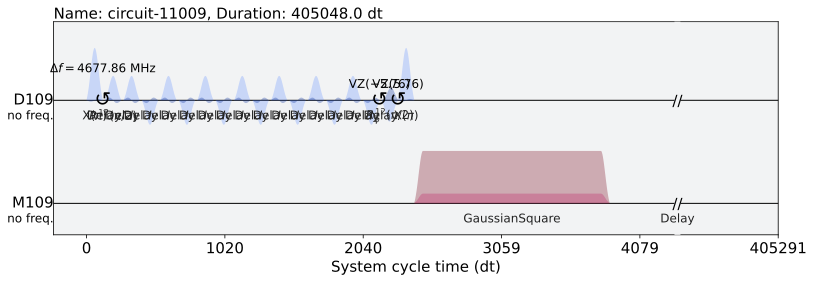

In [80]:
qc_pe_list = init_quantum_circuit()

optimized_beta = 6.0

sx12_gate = gate('SX12', 1)
sx12_params = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_sx12], 'beta': [optimized_beta]}
sx12_sched = schedule_builder(sx12_params, r'$R^{12}(\pi/2)$')

pseudo_gate = gate('Pseudo Identity', 1)
pseudo_params = {'num_pulse': 2, 'angle': [0, 0], 'dur': [dur, dur], 'amp': [amp_sx12, -amp_sx12], 'beta': [optimized_beta, optimized_beta]}
pseudo_sched = schedule_builder(pseudo_params, r'$I$')

for rep in rep_range:
    for angle in angle_swept:
        """
            Amplified phase error sequence circuit
        """
        asx12_gate = gate('ASX12', 1)
        asx12_params = {'num_pulse': 1, 'angle': [angle], 'dur': [dur], 'amp': [-amp_sx12], 'beta': [optimized_beta]}
        asx12_sched = schedule_builder(asx12_params, r'$R_{\phi}^{12}(\pi/2)$')

        ape_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
        ape_circ.x(qubit)
        ape_circ.append(sx12_gate, [qubit])
        for j in range(rep):
            ape_circ.append(pseudo_gate, [qubit])
        ape_circ.append(asx12_gate, [qubit])
        ape_circ.x(qubit)
        ape_circ.measure(qubit, clbit)
        ape_circ.add_calibration(sx12_gate, [qubit], sx12_sched)
        ape_circ.add_calibration(pseudo_gate, [qubit], pseudo_sched)
        ape_circ.add_calibration(asx12_gate, [qubit], asx12_sched)
        ape_circ.add_calibration('measure', [qubit], measure_schedule)
        qc_pe_list.append(ape_circ)

transpiled_circ = qiskit.transpile(qc_pe_list[-1], backend) 
schedule = qiskit.schedule(transpiled_circ, backend)
schedule.filter(channels=[qiskit.pulse.DriveChannel(qubit), qiskit.pulse.MeasureChannel(qubit)]).draw()

In [81]:
pe_job_single = backend.run(qc_pe_list, meas_level=1, meas_return='single', shots=pe_shots)
print(pe_job_single.job_id())
pe_job_id_string = f'{pe_job_single.job_id()}'

cv3m79dhdzz0008mg2t0


In [82]:
pe_job_single.status()

<JobStatus.RUNNING: 'job is actively running'>

In [83]:
pe_job_params = {'pe_job_id_string': pe_job_single.job_id(), 'datetime': datetime.datetime.now(), \
                   'duration': dur, 'num_points': len(qc_pe_list), 'num_shots': pe_shots, \
                   'optimized_beta': optimized_beta,
                   'delay_overlap': True, 
                   'mapping_01': True, 
                   'rep_delay': '0.00025', 
                   'extended_delay': '400032',
                   'idling_circuits': False, 
                   'unconditional_reset12': False}

path = "./calibrator/phase_error1/data/"
folder_name = pe_job_params['pe_job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{pe_job_params['pe_job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(pe_job_params, f)

#### Collect data

In [84]:
job_id_collect = 'cv3m79dhdzz0008mg2t0'
pe_job_single = provider.backend.retrieve_job(job_id_collect)
pe_exp_single = ut.DataAnalysis(experiment=pe_job_single, average=False, shots=pe_shots, qubit=0)
pe_exp_single.retrieve_data(average=False)

with open(f"./{path}/{job_id_collect}/iq_data.pkl", "wb") as f:
    pickle.dump(pe_exp_single.IQ_data, f)

#### Check overall jobs

In [76]:
ran_job = None
for ran_job in provider.backend.jobs():
    print(str(ran_job.job_id()) + " " + str(ran_job.status()))

cv3m6dshdzz0008mg2r0 JobStatus.QUEUED
cv3k37whdzz0008mg0t0 JobStatus.CANCELLED
cv3jx6wx55b0008v4v1g JobStatus.DONE
cv3jp2r12hg0008f2tj0 JobStatus.DONE
cv3jg6gqxmm0008q54zg JobStatus.DONE
cv3jbbnx55b0008v4r80 JobStatus.ERROR
cv3j9rf12hg0008f2s7g JobStatus.ERROR


In [77]:
job = provider.backend.retrieve_job('cv3m6dshdzz0008mg2r0')
job.cancel()

True